In [1]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


In [2]:
data = pd.read_csv('WAG_C_M.csv',';', index_col=['month'], parse_dates=['month'], dayfirst=True)
data.head()

,WAG_C_M
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5


### Визуальный анализ ряда

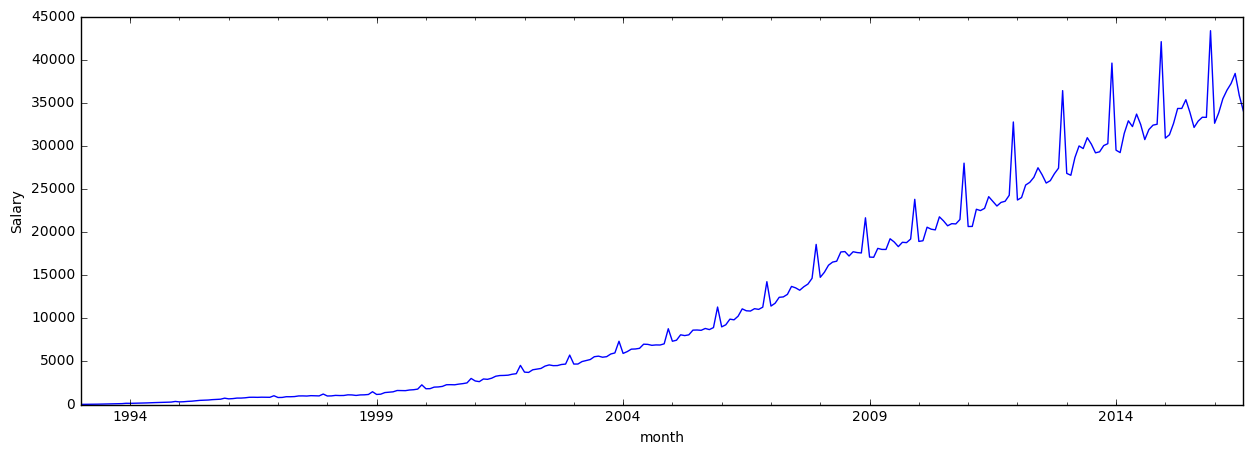

In [3]:
plt.figure(figsize(15,5))
data['WAG_C_M'].plot()
plt.ylabel('Salary')
pylab.show()

Ярко выраженный восходящий тренд, сезонные колебания, ряд нестационарен, требуется стабилизация дисперсии

### Стабилизация дисперсии
Выполним преобразования Бокса-Кокса:

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


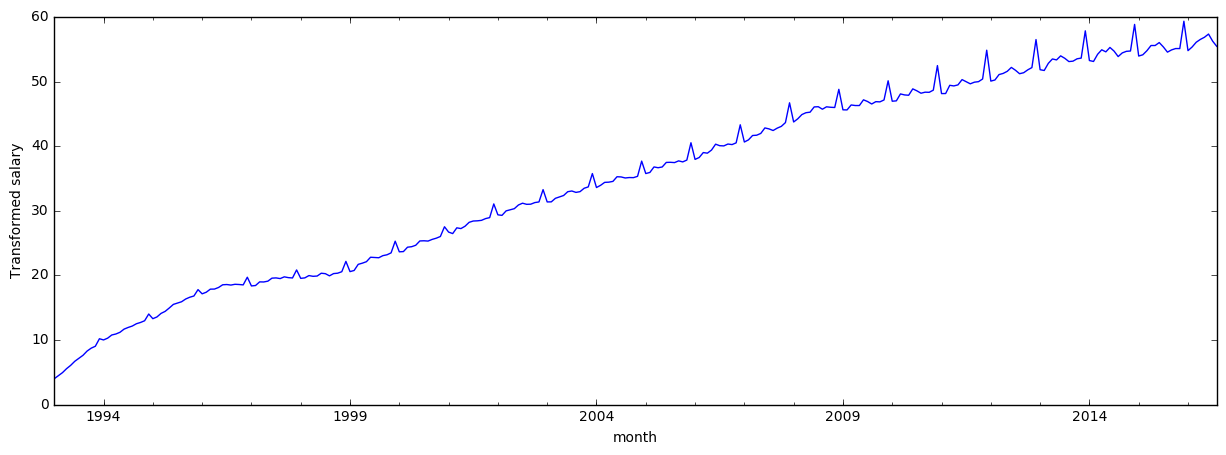

In [4]:
data['salary_box'], lmbda = stats.boxcox(data['WAG_C_M'])
plt.figure(figsize(15,5))
data['salary_box'].plot()
plt.ylabel(u'Transformed salary')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data['salary_box'])[1])

### Стационарность
Критерий Дики-Фуллера отвергает гипотезу нестационарности, но визуально на графике  виден тренд, попробуем привести ряд к стационарному виду с помощью дифференцирования.

Применим сезонное дифференцирование, затем сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:

Критерий Дики-Фуллера: p=0.014697


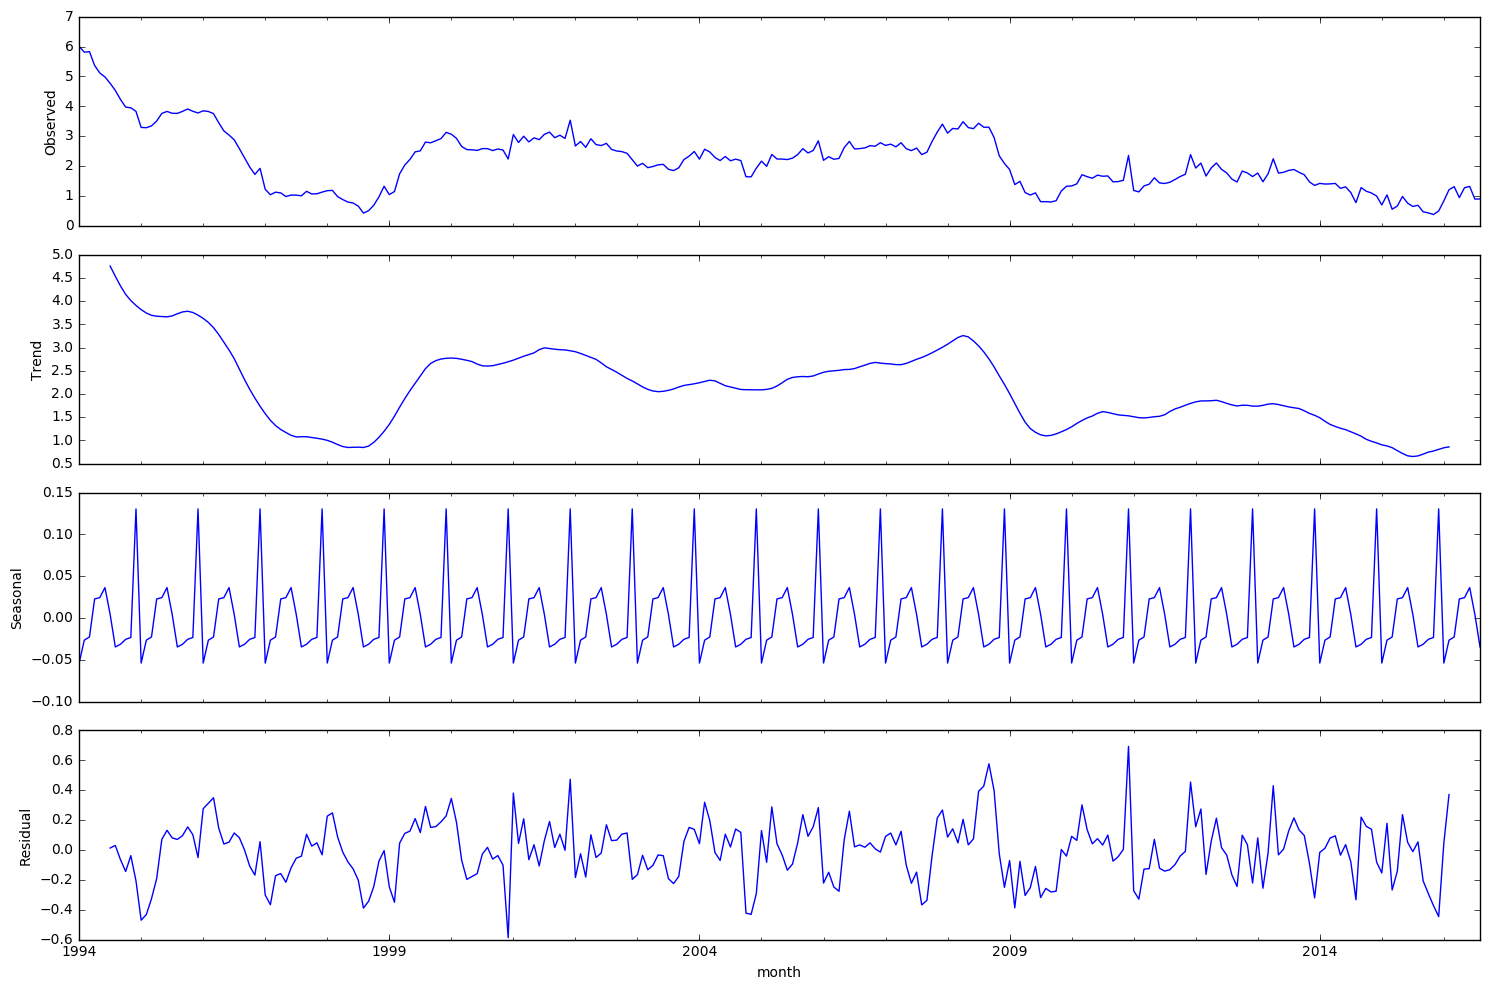

In [5]:
data['salary_box_diff'] = data['salary_box'] - data['salary_box'].shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data['salary_box_diff'][12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data['salary_box_diff'][12:])[1])

Критерий Дики-Фуллера отвергает гипотезу нестационарности, но полностью избавиться от тренда не удалось.

Попробуем добавить ещё обычное дифференцирование:

Критерий Дики-Фуллера: p=0.000000


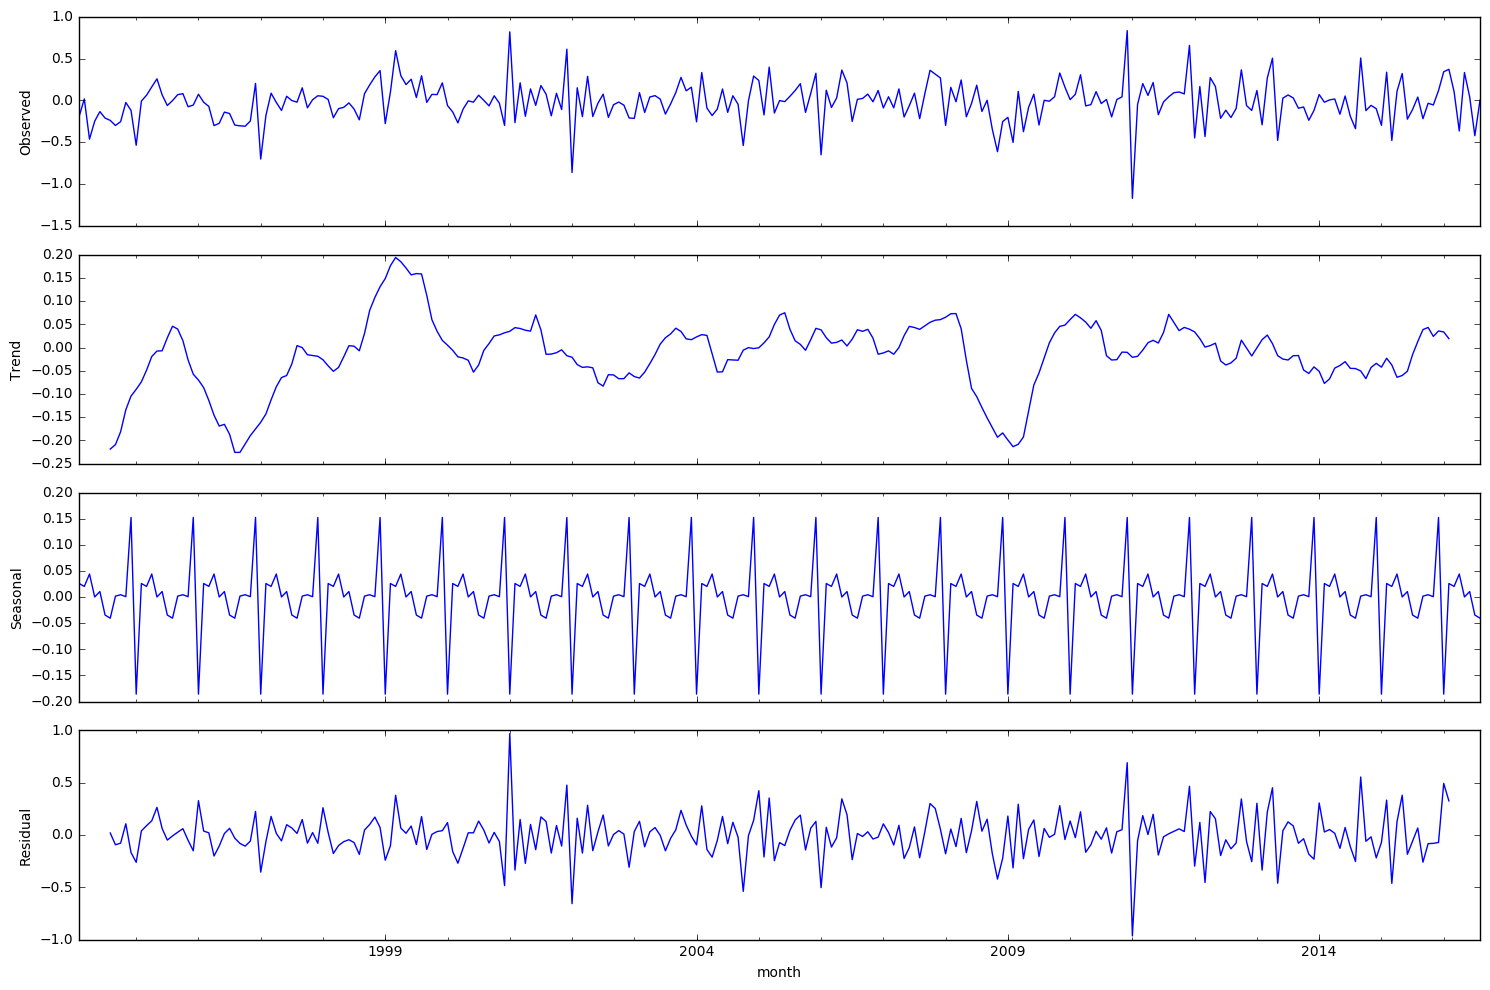

In [6]:
data['wage_box_diff2'] = data['salary_box_diff'] - data['salary_box_diff'].shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data['wage_box_diff2'][13:]).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data['wage_box_diff2'][13:])[1])

Гипотеза нестационарности отвергается, тренд явно не выражен.

### Подбор модели, выбор начальных приближений для $Q,q,P,p$

Посмотрим на ACF и PACF полученного ряда:

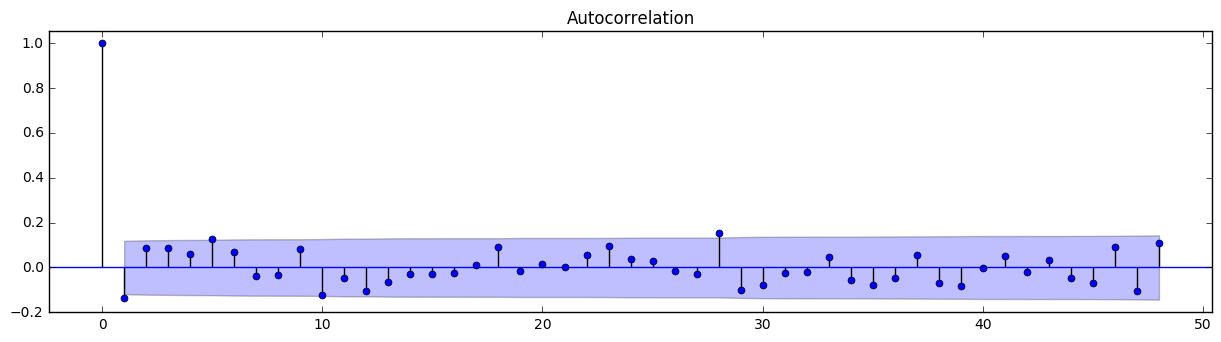

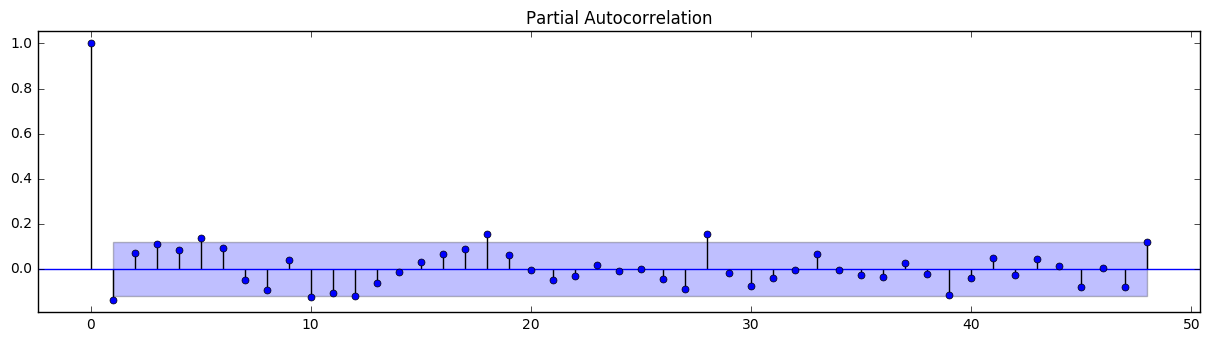

In [7]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data['wage_box_diff2'][13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data['wage_box_diff2'][13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

Начальные приближения: Q=0, q=1, P=0, p=1

In [8]:
ps = range(0, 2)
d=1
qs = range(0, 2)
Ps = range(0, 1)
D=1
Qs = range(0, 1)

In [9]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

4

### Обучение и сравнение моделей-кандидатов

In [11]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data['salary_box'], order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

('wrong parameters:', (0, 0, 0, 0))
Wall time: 8.45 s


In [12]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

     parameters       aic
1  (1, 0, 0, 0)  2.625709
0  (0, 1, 0, 0)  3.369832
2  (1, 1, 0, 0)  4.003439


### Лучшая модель

In [13]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                         salary_box   No. Observations:                  284
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 12)   Log Likelihood                   0.687
Date:                            Sat, 15 Apr 2017   AIC                              2.626
Time:                                    20:32:02   BIC                              9.924
Sample:                                01-01-1993   HQIC                             5.552
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1300      0.048     -2.733      0.006      -0.223      -0.037
sigma2         0.0582      0.004   

### Анализ остатков построенной модели

Критерий Стьюдента: p=0.146496
Критерий Дики-Фуллера: p=0.000000


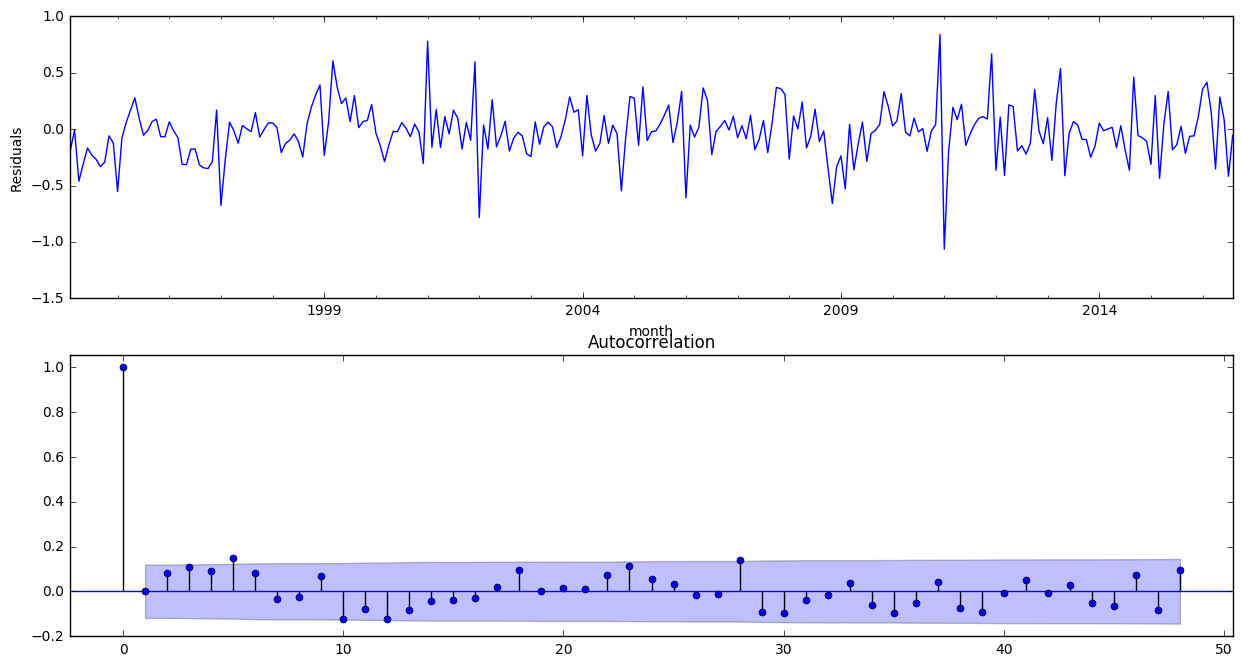

In [16]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой).

Посмотрим, насколько хорошо модель описывает данные:

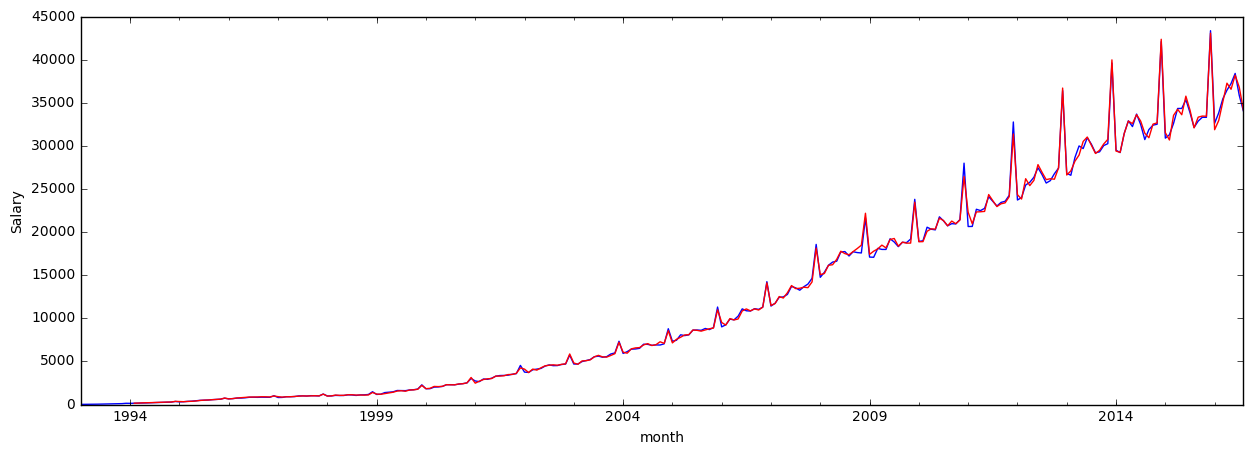

In [18]:
data['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,5))
data['WAG_C_M'].plot()
data['model'][13:].plot(color='r')
plt.ylabel('Salary')
pylab.show()

### Прогноз

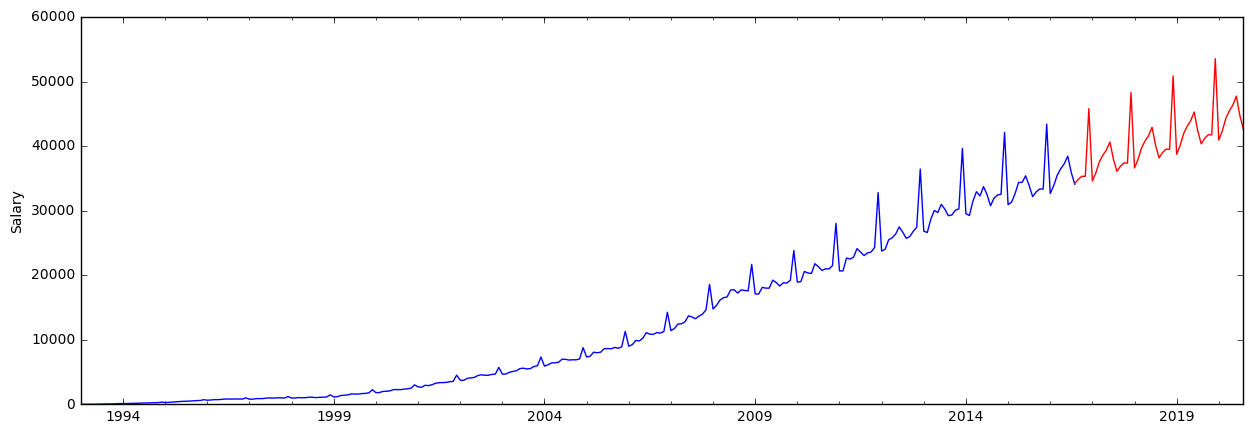

In [28]:
data2 = data[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2016-09-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,48)]
future = pd.DataFrame(index=date_list, columns= salary2.columns)
data2 = pd.concat([data2, future])
data2['forecast'] = invboxcox(best_model.predict(start="2016-08-01", end="2020-08-01"), lmbda)

plt.figure(figsize(15,5))
data2['WAG_C_M'].plot()
data2['forecast'].plot(color='r')
plt.ylabel('Salary')
pylab.show()